# KAIST Summer Session 2018

## Sequence-to-Sequence_Reply Bot (08.23.2018)

- This code is adapted from https://github.com/DSKSD/DeepNLP-models-Pytorch.

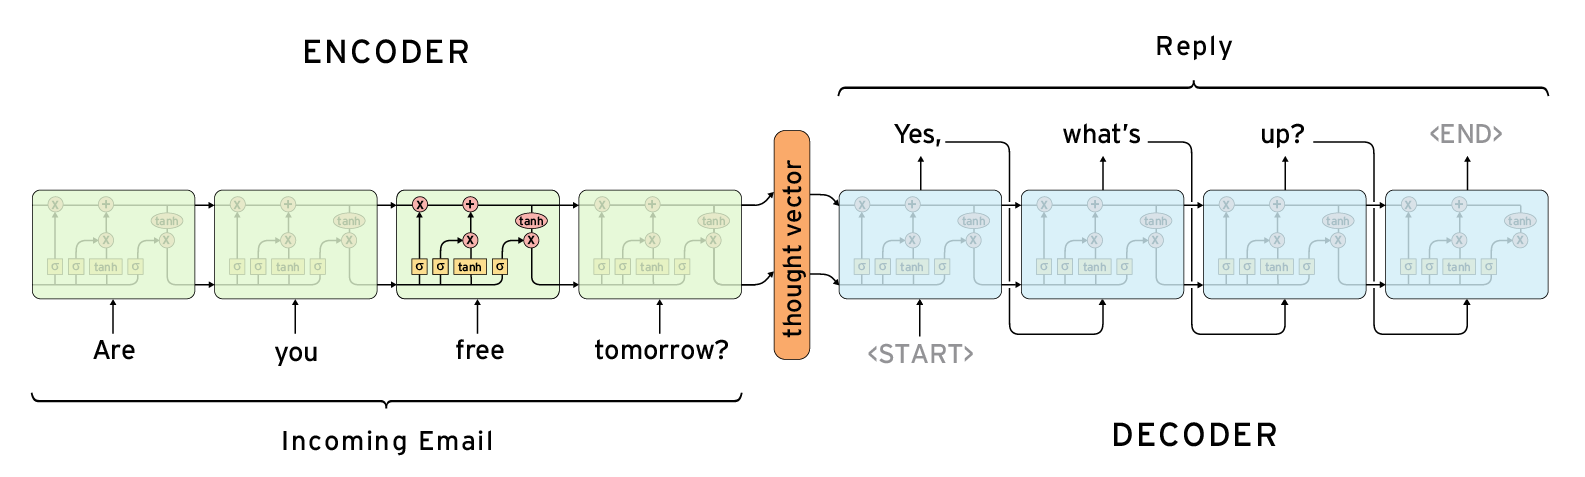

### 0. Data Preparation

In [1]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

MAX_LENGTH = 10
hidden_size = 256
learning_rate = 0.01
dropout_p = 0.1
n_layers = 1
n_epochs = 200

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def normalizeString(s):
    s = re.sub('[./?!\']', '', s)
    s = re.sub('\ufeff', '', s)
    return s.lower()


def lengthfilter(pairs):
    return [pair for pair in pairs if len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH]


def prepareData():
    lines = open('reply bot.csv').read().strip().split('\n')    
    pairs = [[normalizeString(s) for s in l.split(',')] for l in lines]
    input_lang = Lang('input')
    output_lang = Lang('output')
    pairs = lengthfilter(pairs)
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        print(pair)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:", input_lang.n_words + output_lang.n_words)
    return input_lang, output_lang, pairs


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [4]:
input_lang, output_lang, pairs = prepareData()

training_pairs = [tensorsFromPair(pairs[i]) for i in range(len(pairs))]

Read 12 sentence pairs
['나 살찐 거 같지', '예뻐']
['나 요즘 살찐 거 같지', '예뻐보여']
['나 어때', '예쁘네']
['오늘 옷 어때', '예뻐']
['이 옷 잘 어울려', '예쁘다']
['오늘 나 어때', '완전 예뻐']
['나 힘들어', '부장님이 잘못했네']
['컨디션 최악이야', '부장님이 잘못했군']
['오늘 회사에서 힘들었어', '부장님이 잘못했어']
['회사 관두고 싶어', '부장님이 잘못한거 같아']
['짜증나', '부장님이 완전 잘못했네']
['오늘 있잖아', '부장님이 잘못했잖아']
Counted words: 37


### 1. Define a Neural Network

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output,(hidden, cell) = self.lstm(embedded,(hidden, cell))
        return output, hidden, cell

    def init_hidden_cell(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        cell = torch.zeros(self.n_layers, 1, self.hidden_size)
        return hidden,cell

    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = F.relu(self.dropout(embedded))
        output,(hidden, cell) = self.lstm(embedded,(hidden, cell))
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden,  cell

    def init_hidden_cell(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        cell = torch.zeros(self.n_layers, 1, self.hidden_size)
        return hidden, cell

### 2. Define a Loss Function and Optimizer

In [6]:
# Instantiate the seq2seq model
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = DecoderRNN(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Set loss and optimizer function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

### 3. Training

In [7]:
print_every = n_epochs//10
print_loss_total = 0

encoder.train()
decoder.train()

for epoch in range(1, n_epochs+1):
    for i in range(len(pairs)):
        training_pair = training_pairs[i]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1] 
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0
    
        # Encoding
        encoder_hidden, encoder_cell = encoder.init_hidden_cell()
    
        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)

        
        # Decoding using the encoded representation    
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing


        # Updating
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
            
        loss.backward()
            
        encoder_optimizer.step()
        decoder_optimizer.step()            
            
        print_loss_total += loss.item()
        
        
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('Epoch {:d} ({:.0f}%) {:.4f}'.format(epoch, epoch / n_epochs * 100, print_loss_avg))
        
print("Learning finished!")

Epoch 20 (10%) 20.0447
Epoch 40 (20%) 1.3276
Epoch 60 (30%) 0.0360
Epoch 80 (40%) 0.0122
Epoch 100 (50%) 0.0067
Epoch 120 (60%) 0.0043
Epoch 140 (70%) 0.0029
Epoch 160 (80%) 0.0021
Epoch 180 (90%) 0.0016
Epoch 200 (100%) 0.0012
Learning finished!


### 4. Evaluation

In [8]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.init_hidden_cell()

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)


        decoder_input = torch.tensor([[SOS_token]])  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

- Let's see how the model works well

In [13]:
for i in range(5):
    pair = random.choice(pairs)
    print('Question: ', pair[0])
    output_words = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print('Reply Bot\'s Answer: ', output_sentence)
    print('')

Question:  컨디션 최악이야
Reply Bot's Answer:  부장님이 잘못했군 <EOS>

Question:  나 어때
Reply Bot's Answer:  예쁘네 <EOS>

Question:  오늘 회사에서 힘들었어
Reply Bot's Answer:  부장님이 잘못했어 <EOS>

Question:  오늘 나 어때
Reply Bot's Answer:  완전 예뻐 <EOS>

Question:  이 옷 잘 어울려
Reply Bot's Answer:  예쁘다 <EOS>

